In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from wordcloud import WordCloud
import re
import pickle
from xgboost import XGBClassifier

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(r"amazon_alexa.tsv", delimiter='\t')

In [3]:
df.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.shape

(3150, 5)

In [5]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.describe()

,rating,feedback
count,3149.000000,3149.000000
mean,4.463957,0.918704
std,1.067773,0.273332
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [8]:
df["length"] = df["verified_reviews"].apply(len)

In [9]:
df

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   date              3149 non-null   object
 2   variation         3149 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3149 non-null   int64 
 5   length            3149 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 172.2+ KB


In [11]:
df["feedback"].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

## Analyzing 'rating' column

In [12]:
df["rating"].value_counts()


# Conclusion feedback(0) = rating[0] + rating[1]
# feedback(1) = rating[3] + rating[4] + rating[5]

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

<Axes: xlabel='rating'>

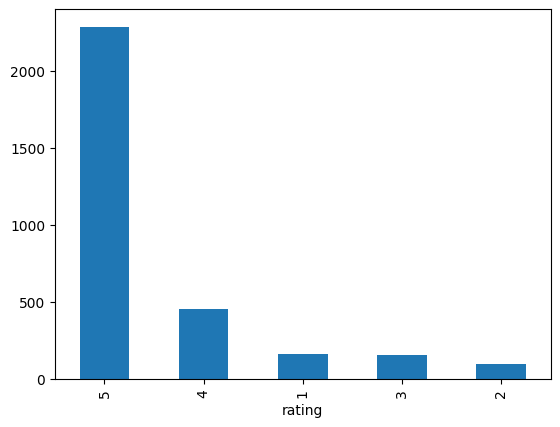

In [13]:
df["rating"].value_counts().plot(kind='bar')

In [14]:
# %age of rating

(df["rating"].value_counts()/df.shape[0])*100

rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: count, dtype: float64

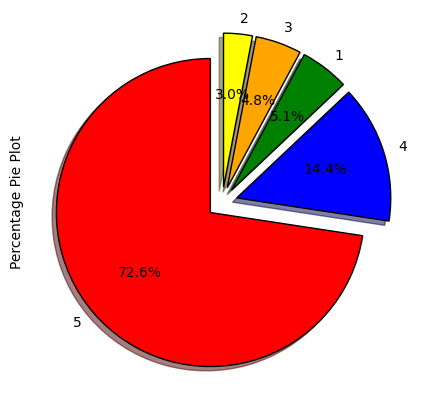

In [15]:
fig = plt.figure(figsize= (5,5))
colors = ['red', 'blue', 'green', 'orange', 'yellow','black']
wp = {"linewidth": 1, "edgecolor": "black"}
tags = df["rating"].value_counts()/df.shape[0]
explode = [0.1, 0.1, 0.1, 0.1, 0.1]
tags.plot(kind='pie', autopct= "%1.1f%%", shadow= True, colors=colors, startangle=90, wedgeprops= wp, explode= explode, label="Percentage Pie Plot")

from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format= "png")

## Analyzing 'feedback' column

In [16]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [17]:
review0 = df[df['feedback'] == 0].iloc[0]['verified_reviews']
review1 = df[df['feedback'] == 1].iloc[0]['verified_reviews']

feedback0 = df[df['feedback'] == 0]['rating'].value_counts()
feedback1 = df[df['feedback'] == 1]['rating'].value_counts()

In [18]:
feedback0

rating
1    161
2     95
Name: count, dtype: int64

<Axes: xlabel='feedback'>

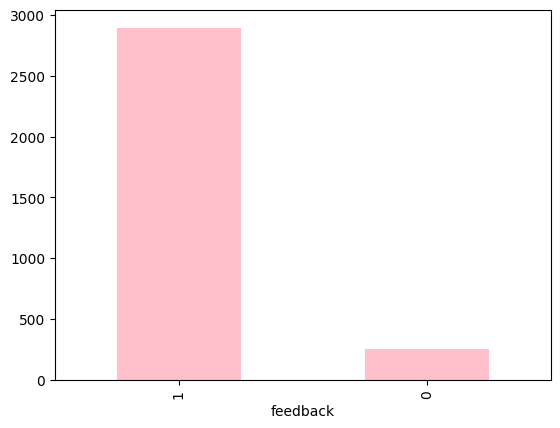

In [19]:
df['feedback'].value_counts().plot(kind= 'bar', color= 'pink')

## Analyzing 'variation' column

In [20]:
df["variation"].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

In [21]:
df["variation"].nunique()

16

In [22]:
# Average Rating by variation

df.groupby("variation")["rating"].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

## Analyzing "length" column

In [23]:
df["length"].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Length of reviews for negative feedback')]

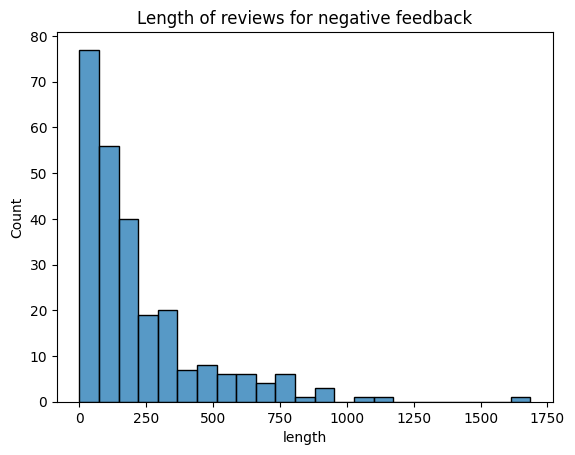

In [24]:
sns.histplot(df[df['feedback'] == 0]['length']).set(title= "Length of reviews for negative feedback")

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Length of reviews for positive feedback')]

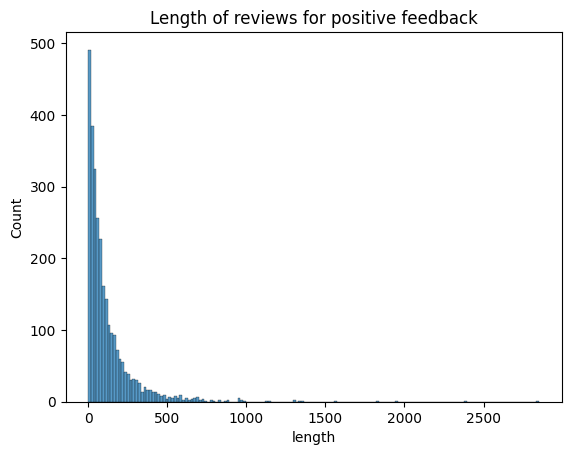

In [25]:
sns.histplot(df[df['feedback'] == 1]['length']).set(title= "Length of reviews for positive feedback")

Text(0.5, 1.0, 'WordCloud for reviews')

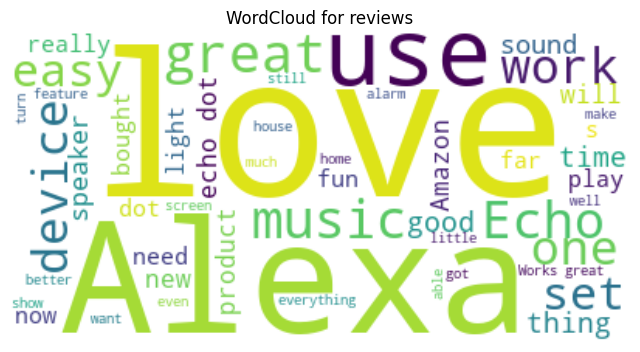

In [26]:
# Combine all values
reviews = " ".join([rev for rev in df["verified_reviews"]])

# Wordcloud

wc = WordCloud(background_color='white', max_words=50).generate(reviews)
plt.figure(figsize= (8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for reviews")

Text(0.5, 1.0, 'WordCloud for positive reviews')

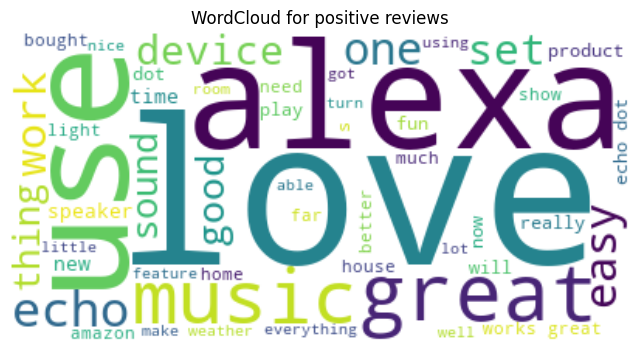

In [27]:
positive_reviews = " ".join(rev for rev in df[df['feedback'] == 1]['verified_reviews'])
positive_reviews = positive_reviews.lower().split()
positive_reviews = " ".join(positive_reviews)

# Wordcloud

wc = WordCloud(background_color='white', max_words=50).generate(positive_reviews)
plt.figure(figsize= (8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for positive reviews")

Text(0.5, 1.0, 'WordCloud for negative reviews')

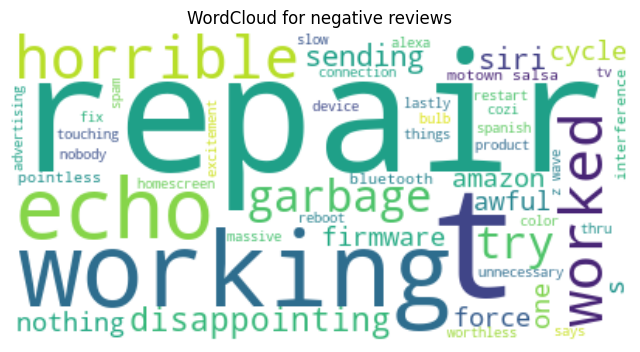

In [28]:
negative_reviews = " ".join(rev for rev in df[df['feedback'] == 0]['verified_reviews'])
negative_reviews = negative_reviews.lower().split()
unique_negative = [x for x in negative_reviews if x not in positive_reviews]
negative_reviews = " ".join(unique_negative)

# Wordcloud

wc = WordCloud(background_color='white', max_words=50).generate(negative_reviews)
plt.figure(figsize= (8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for negative reviews")

# Preprocessing and modelling

In [29]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df["verified_reviews"])

In [30]:
stemmer = PorterStemmer()
corpus = []

for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', " ", df.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = " ".join(review)
    corpus.append(review)

In [31]:
corpus

['love echo',
 'love',
 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon cannot use mani featur ipad see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons seem smartbon polit yet',
 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great',
 'sent year old dad talk constantli',
 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time',
 'purchas mother knee problem give someth tri come get around fast like enjoy littl big thing ale

In [32]:
# Using Count Vectorizer to create bag of words

cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values


# Saving the cv
pickle.dump(cv, open('model/CV.pkl', 'wb'))

In [33]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [34]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Scaling the values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Saving the scaler
pickle.dump(scaler, open('model/scaler.pkl', 'wb'))

## Random Forest

In [35]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scaled, y_train)
rf_train_acc = model_rf.score(X_train_scaled, y_train)
rf_test_acc = model_rf.score(X_test_scaled, y_test)

In [36]:
print("Training set accuracy:", rf_train_acc)
print("Test set accuracy:", rf_test_acc)

Training set accuracy: 0.9940452560539896
Test set accuracy: 0.9365079365079365


In [37]:
y_pred = model_rf.predict(X_test_scaled)

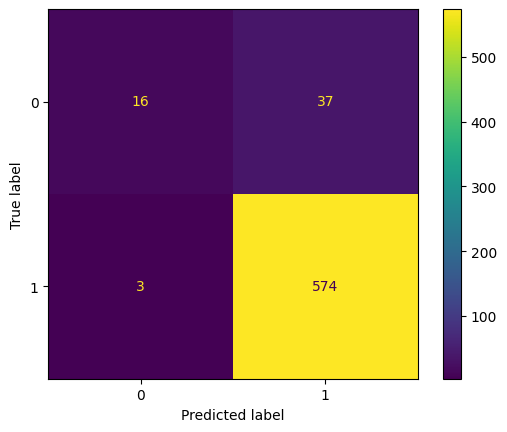

In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=model_rf.classes_)

cm_display.plot()

In [39]:
# K-Fold cross validation

accuracies = cross_val_score(estimator=model_rf, X = X_train_scaled, y= y_train, cv=10)
accuracy = accuracies.mean()
std_deviation = accuracies.std()

In [40]:
accuracies

array([0.94444444, 0.93650794, 0.94047619, 0.94444444, 0.94047619,
       0.94047619, 0.94444444, 0.94047619, 0.93650794, 0.94023904])

In [41]:
accuracy

0.9408493012078669

In [42]:
std_deviation

0.002782073330022185

In [53]:
pickle.dump(scaler, open('model/random_forest.pkl', 'wb'))

# XgBoost

In [51]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
print("Training data accuracy", model_xgb.score(X_train_scaled, y_train))
print("Testing data accuracy", model_xgb.score(X_test_scaled, y_test))

Training data accuracy 0.9749900754267566
Testing data accuracy 0.9380952380952381


In [55]:
y_pred_xgb = model_xgb.predict(X_test_scaled)

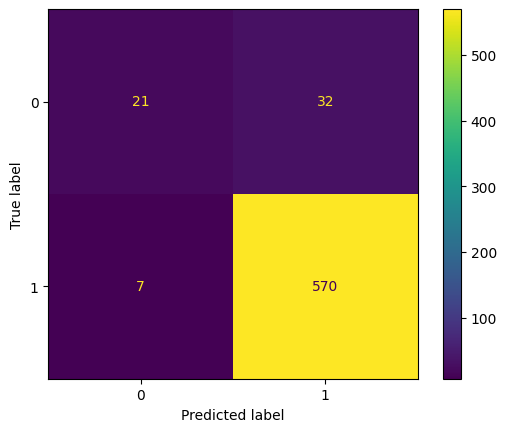

In [56]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=model_xgb.classes_)
cm_display.plot()

In [58]:
pickle.dump(scaler, open('model/xgb.pkl', 'wb'))

In [59]:
# Decision Tree Classifier

model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [61]:
print("Training accuracy :", model_dtc.score(X_train_scaled, y_train))
print("Testing accuracy :", model_dtc.score(X_test_scaled, y_test))

Training accuracy : 0.9940452560539896
Testing accuracy : 0.9079365079365079


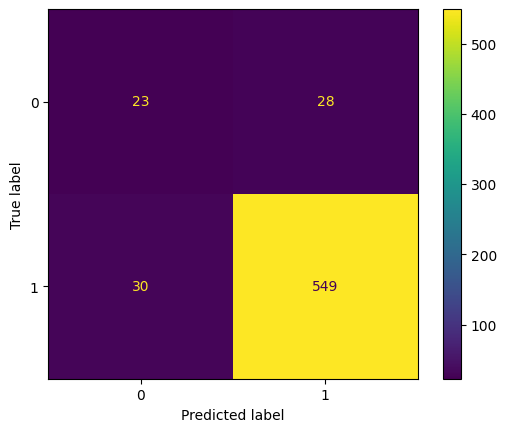

In [62]:
y_pred_dtc = model_dtc.predict(X_test_scaled)
# Confusion Matrix

cm = confusion_matrix(y_pred_dtc, y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=model_dtc.classes_)
cm_display.plot()

In [63]:
pickle.dump(scaler, open('model/dtc.pkl', 'wb'))